# A Toy Model of Adverse Selection in Insurance - Kreps (2023)
## Chapter 20 in MF II

Import libraries

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Regulated Monopoly

Assumptions:
- All consumers have CARA utility functions and are expected utilty maximizers
- Insurance company offers full insurance and sets premium = expected average cost

Define a Consumer class for creating individual types

In [74]:
class Consumer():
    """Consumer has a coefficient of risk aversion, a probability of loss, and wealth"""

    def __init__(self, λ=2, π=.5, W=1000, L=5000):
        # Unpack parameters
        self.λ, self.π, self.W, self.L = λ, π, W, L

    def u(self, x):
        """Utility index"""
        return -np.exp(-self.λ*x)

    def EU(self, p=0, t=0):
        """Expected utility of insurance contract at premium p and transfer t
           in the event of loss; default is no insurance"""
        return self.π*self.u(-self.L - p + t) + (1-self.π)*self.u(-p)

    def D(self, p=0, t=0):
        """Demand for insurance contract with premium p and transfer t
           in the event of loss"""
        return 1 if self.EU(p, t) > self.EU() else 0

    def CE(self, p=0, t=0):
        """Certainty equivalent of lottery induced by insurance contract with premium p
           and transfer t in the event of loss"""
        return np.log(-self.EU(p, t)) / self.λ
    #TODO - generalize for non CARA utility: admit a function as an input for utility index and review CE function

    #TODO - add a function for calculating WTP (this is different from CE above)

Define a Market class for simulating outcomes

In [66]:
class Market():
    """ Market class takes two inputs:
        1. A list of tuples, where the first element in each tuple is a consumer type
        and the second element is the frequency of that type in the population
        2. An optional tuple (p, t) describing the premium and transfer in the
        event of loss that is currently offered by the regulated monopoly"""

    def __init__(self, L, z=(0, 0)):
        # Unpack contract
        self.z = z
        p, t = z
        # Unpack list in dataframe and create column for attributes of each type
        self.df_C = pd.DataFrame(L, columns=['C', 'n'])
        df_C = self.df_C
        df_C['λ'] = df_C['C'].apply(lambda x: x.λ)
        df_C['π'] = df_C['C'].apply(lambda x: x.π)
        df_C['W'] = df_C['C'].apply(lambda x: x.W)
        df_C['L'] = df_C['C'].apply(lambda x: x.L)

        # Compute demand for each type (D=1 if purchases, 0 otherwise)
        df_C['D'] = df_C['C'].apply(lambda x: x.D(p=p, t=t))

        # Calculate WTP for each type
        df_C['WTP'] = df_C['C'].apply(lambda x: x.CE(p=p, t=t))

        # Calculate total demand, average cost, revenue, and profit at current contract
        self.D = sum(df_C['D']*df_C['n'])
        self.AC = sum(df_C['π']*df_C['L']*df_C['D']*df_C['n']) / self.D if self.D > 0 else 0
        self.R = p*self.D
        self.Π = self.R - self.AC*self.D
        self.N = sum(df_C['n'])
        self.d = self.D / self.N
        self.π = self.Π / self.N

    def update_contract(self, p=0, t=0):
        """Update contract and calculate new values """
        self.z = (p, t)
        # Manipulate dataframe
        df_C = self.df_C
        df_C['D'] = df_C['C'].apply(lambda x: x.D(p=p, t=t))
        df_C['WTP'] = df_C['C'].apply(lambda x: x.CE(p=p, t=t))
        # Update dataframe
        self.df_C = df_C
        # Update scalars
        self.D = sum(df_C['D']*df_C['n'])
        self.d = self.D / self.N
        self.AC = sum(df_C['π']*df_C['L']*df_C['D']*df_C['n']) / self.D if self.D > 0 else 0
        self.R = p*self.D
        self.Π = self.R - self.AC*self.D
        self.π = self.Π / self.N
        # Update dataframe
        self.df_C = df_C

    def demand(self, p=0, t=0):
        """Relative demand for insurance contract with premium p and transfer t in the event of loss"""
        self.update_contract(p, t)
        return self.d

    def avc(self, p=0, t=0):
        """Average cost of insurance contract with premium p and transfer t in the event of loss"""
        self.update_contract(p, t)
        return self.AC

    def mc(self, p=0, t=0, h=1):
        """Marginal cost of insurance contract with premium p and transfer t in the event of loss
            Note: we compute the incremental cost divided by the incremental demand (where incremental
            is determined by step of size h)"""
        self.update_contract(p, t)
        C0 = self.AC * self.D
        D0 = self.D
        p_new = p - h
        self.update_contract(p_new, t)
        C1 = self.AC * self.D
        D1 = self.D
        return (C1 - C0) / (D1 - D0) if D1 > D0 else None

    def wtp_bounds(self, p=0, t=0):
        """Maximum willingness to pay for insurance contract"""
        self.update_contract(p, t)
        return max(self.df_C['WTP']) , min(self.df_C['WTP'])

    def prof(self, p=0, t=0):
        """Profit from insurance contract with premium p and transfer t in the event of loss"""
        self.update_contract(p, t)
        return self.Π


Create a market with 1,100 consumers of types described in p. 122-3

In [67]:
n = 10 # constant number of consumers per type
L = [(Consumer(λ=λ, π=π, L=5000), n) for λ in np.arange(.0001, 0.00021, .00001)
     for π in np.arange(.01, .11, .01)]
M = Market(L)

Plot demand for full insurance across types at different premiums (Figure 20.1)

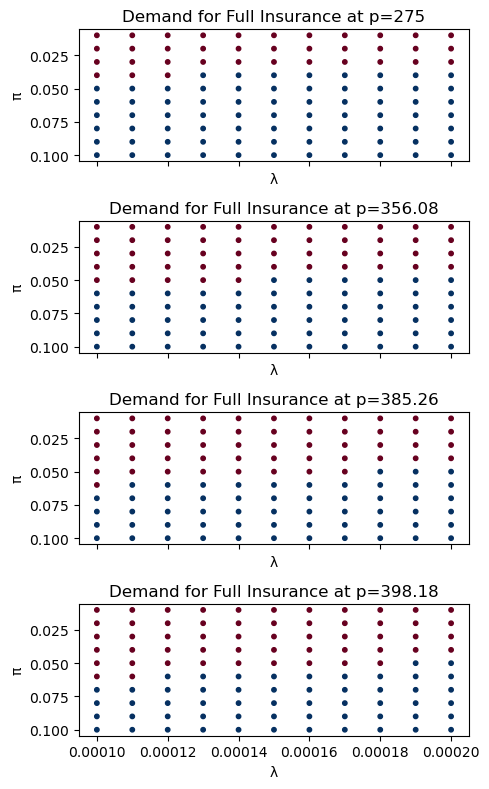

In [68]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

# Loop over premiums
for D in [(ax1, 275), (ax2, 356.08), (ax3, 385.26), (ax4, 398.18)]:
    ax, p = D
    M.update_contract(p, 5000)
    ax.scatter(M.df_C['λ'], M.df_C['π'], c=M.df_C['D'], cmap='RdBu', s=10)
    ax.set_ylabel('π')
    ax.set_xlabel('λ')
    ax.set_title('Demand for Full Insurance at p=' + str(p))
    ax.set_ylim(ax.get_ylim()[::-1])

# Make wider
fig.set_size_inches(5, 8)

# Plot legend
plt.tight_layout()
plt.show()

In [69]:
#TODO: add analytical solution for lines?

When p = 398.18, AC is equal to the premium, so the firm breaks even (as per regulation):

In [70]:
print(M.avc(p=398.18, t=5000))

398.1818181818182


This is easier to see if we plot market demand and cost curves à la Einav, Finkelstein and Cullen (2010):

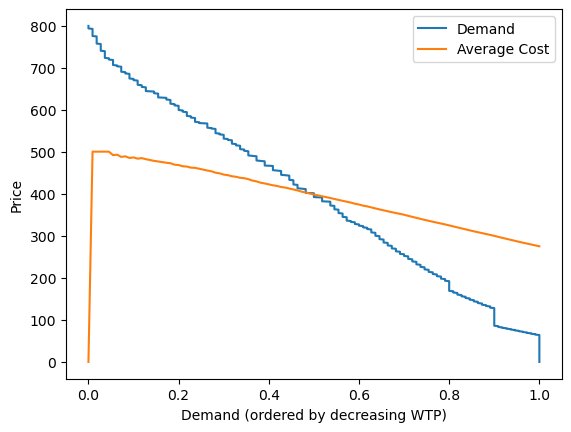

In [71]:
y_p = [i for i in range(0, 800, 1)]
x_d = [M.demand(p=i, t=5000) for i in y_p]
y_av = [M.avc(p=i, t=5000) for i in y_p]
y_mc = [M.mc(p=i, t=5000, h=1) for i in y_p]
plt.plot(x_d, y_p, label='Demand')
plt.plot(x_d, y_av, label='Average Cost')
# plt.scatter(x_d, y_mc, label='Marginal Cost')
plt.legend()
plt.xlabel('Demand (ordered by decreasing WTP)')
plt.ylabel('Price')
plt.show()

Plot profit as a function of price to see that firm maximizes profits by setting $p$ around $567:

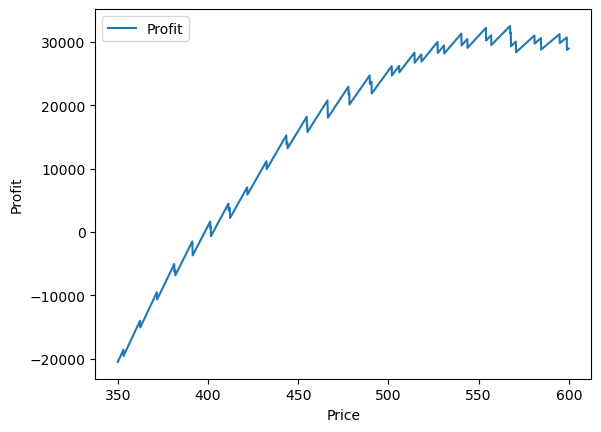

In [72]:
# Plot profit as a function of price
y_p = [i for i in np.arange(350, 600, .1)]
y_Π = [M.prof(p=i, t=5000) for i in y_p]
plt.plot(y_p, y_Π, label='Profit')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Profit')
plt.show()

Calculate profits at $p$= $567.44:

In [73]:
print(M.prof(p=567.44, t=5000))

32557.600000000006


## References
Einav, Liran, Amy Finkelstein, and Mark R. Cullen. "Estimating welfare in insurance markets using variation in prices." The quarterly journal of economics 125.3 (2010): 877-921.

Kreps, David M. Microeconomic Foundations II: Imperfect Competition, Information, and Strategic Interaction. Princeton University Press, 2023.

